# Test LayoutLMv3 for Token classification

The task of token classification in the field of documents intelligence consists of correctly labeling the parts of a document image. That is detecting regions of the document page by drawing bounding boxes around them and classification them among categories (in our case: Caption, Footnote, Formula, List-item, page-footer, Page-header, Picture, Section-header, Table, Text, Title).

In [1]:
from transformers import LayoutLMv3Processor, LayoutLMv3Model
from datasets import load_from_disk, Features, Sequence, ClassLabel, Value, Array2D, concatenate_datasets
from PIL import Image, ImageDraw, ImageFont
from functools import partial

/home/pietro/miniconda3/envs/tfx_ai_document_analysis/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load dataset

In [2]:
dataset = load_from_disk("../data/raw/DocLayNet-small")
# dataset.set_format("pandas")
dataset = dataset.remove_columns(['bboxes_line','page_hash','original_filename','page_no','coco_width','coco_height','collection','original_width','original_height','num_pages'])
ds_train = dataset['train']

### Load processor for tokenization

Tokenization is necessary for step for preprocessing the data to be the input of a transformer model. The huggingface API allows to directly load a processor model "LayoutLMv3Processor" with a specific checkpoint "microsoft/layoutlmv3-base"

In [3]:
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

2024-02-06 03:52:50.361096: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Process dataset and create features


In [4]:
# We get the column names of the features used
features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "texts"
boxes_column_name = "bboxes_block"
label_column_name = "categories"
label_list = features[label_column_name].feature.names

# We define a functino to apply on the dataset to process
def prepare_examples(examples):
    images = examples[image_column_name]
    words = examples[text_column_name]
    boxes = examples[boxes_column_name]
    word_labels = examples[label_column_name]
    
    encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                        truncation=True, padding="max_length")
    return encoding

# Create mapping from id2label and label2id, this will be usuful for model output conversion
id2label = {k: v for k,v in enumerate(label_list)}
label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [5]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

# Process training dataset by parts, so as to not cause memory overload
for i in range(len(dataset["train"])//150 + 1):
    train_dataset_part = dataset["train"].select([i for i in range(i*150, min((i+1)*150, len(dataset["train"]))) ]).map(
        prepare_examples,
        batched=True,
        remove_columns=column_names,
        features=features)
    if i == 0:  train_dataset = train_dataset_part
    else:       train_dataset = concatenate_datasets([train_dataset_part,train_dataset])

# Process evaluation dataset
val_dataset = dataset["validation"].select([i for i in range(len(dataset["validation"]))]).map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features)

# Process test dataset
test_dataset = dataset["test"].select([i for i in range(len(dataset["test"]))]).map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features)

Map: 100%|██████████| 150/150 [00:12<00:00, 12.27 examples/s]


### Verfication of data format

In [6]:
import torch

train_dataset.set_format("torch")
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)
    
# print(processor.tokenizer.decode(train_dataset[0]["input_ids"]))
# for id, label in zip(train_dataset[0]["input_ids"],train_dataset[0]["labels"]):
#     print(processor.tokenizer.decode([id]), label.item())

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


### Define the model
Again we use the huggingface API to load a model for TokenClassification with a specific checkpoint available on the website.

In [7]:
from transformers import LayoutLMv3ForTokenClassification
model = LayoutLMv3ForTokenClassification.from_pretrained("../models/Mit1208_layoutlmv3-finetuned-DocLayNet",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at ../models/Mit1208_layoutlmv3-finetuned-DocLayNet and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define the metrics

In [10]:
from datasets import load_metric
import numpy as np

metric = load_metric("seqeval")

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)]
    
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

/home/pietro/miniconda3/envs/tfx_ai_document_analysis/lib/python3.8/site-packages/datasets/load.py:752: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


### Define Training arguments and trainer

In [11]:
from transformers import TrainingArguments, Trainer
# Define training arguments
training_args = TrainingArguments(output_dir="../models/pietro_layoutlmv3-finetune-DocLayNet",
                                  max_steps=1000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=5,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")


from transformers.data.data_collator import default_data_collator
# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

### Train model

In [9]:
trainer.train()

NameError: name 'trainer' is not defined

### Evaluate model

In [ ]:
trainer.evaluate()

: 

### Inference

transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("../models/pietro_layoutlmv3-finetune-DocLayNet")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/pietro/miniconda3/envs/tfx_ai_document_analysis/lib/python3.8/site-packages/transformers/modeling_utils.py:993: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


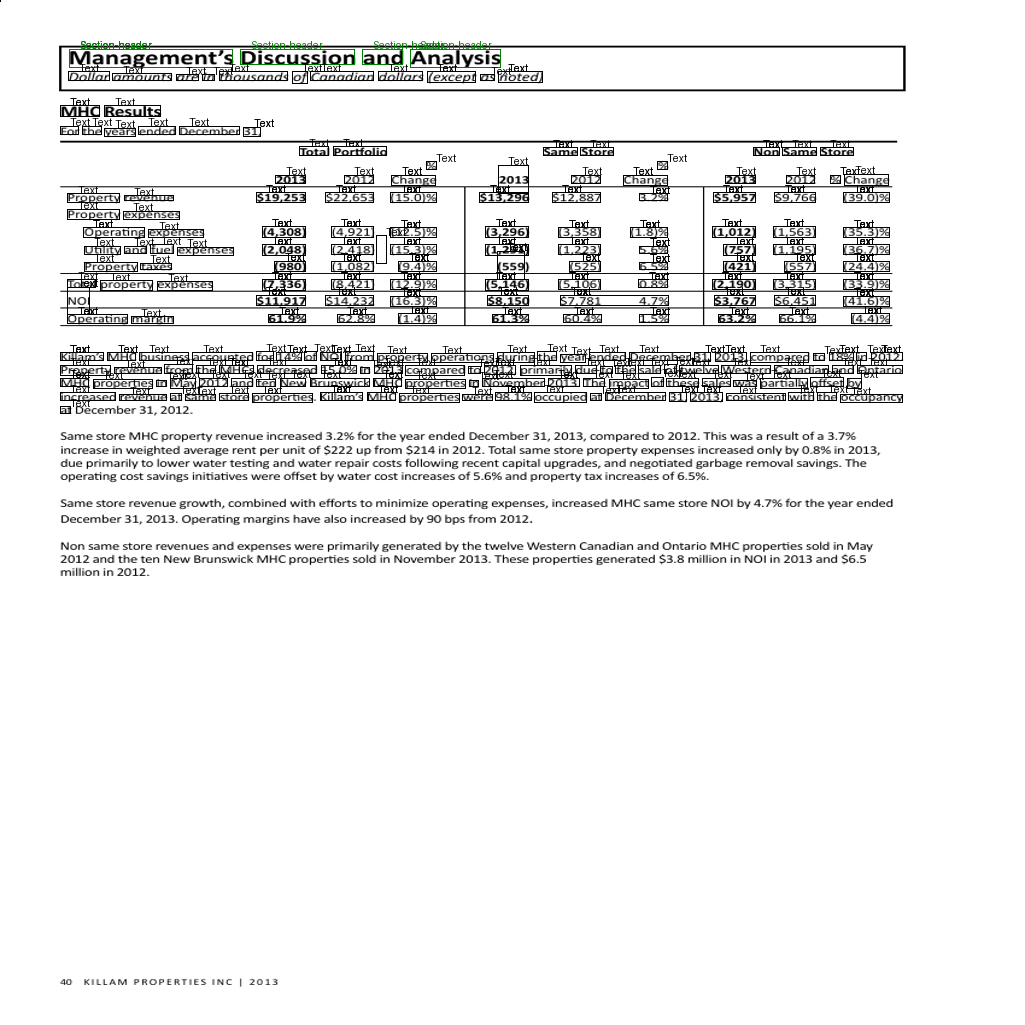

In [61]:
from transformers import LayoutLMForTokenClassification, LayoutLMv2Processor
from PIL import Image, ImageDraw, ImageFont
import torch

# load model and processor from huggingface hub
model = LayoutLMv3ForTokenClassification.from_pretrained("Mit1208/layoutlmv3-finetuned-DocLayNet",
                                                         id2label=id2label,
                                                         label2id=label2id)
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base")

# helper function to unnormalize bboxes for drawing onto the image
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]
    
label2color = {
    "Caption":"red",
    "Footnote":"blue",
    "Formula":"green",
    "List-item":"yellow",
    "Page-footer":"black",
    "Page-header":"red",
    "Picture":"blue",
    "Section-header":"green",
    "Table": "yellow",
    "Text": "black",
    "Title": "blue"
    }

# draw results onto the image
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image


# run inference
def run_inference(image, model=model, processor=processor, output_image=True):
    # create model input
    encoding = processor(image, truncation=True ,return_tensors="pt")
    del encoding["pixel_values"]
    # run inference
    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    # get labels
    labels = [model.config.id2label[prediction] for prediction in predictions]
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels


run_inference(dataset["test"][1]['image'])